In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import re
import html
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

## LOAD DATA

In [2]:
data = []

with open("part-r-00000") as file:
    lines = file.readlines()
    for line in tqdm(lines):
        line = line.strip()
        keys, count = line.split("\t")
        year, month, sentiment, rating, asid = keys.split("-")

        # Add to list as a dictionary
        data.append({
            "year": year,
            "month": month,
            "sentiment": sentiment,
            "rating": rating,
            "asid": asid,
            "count": int(count)
        })

100%|██████████| 12596062/12596062 [00:09<00:00, 1359481.01it/s]


In [3]:
# Create DataFrame from the list of dicts
df = pd.DataFrame(data)
df['year'] = df['year'].astype(int)
# Filter out years before 2010
df = df[df['year'] >= 2010]
df.head()

,year,month,sentiment,rating,asid,count
24802,2010,01,Negative,1,B00000J47L,1
24803,2010,01,Negative,1,B00006ANDQ,3
24804,2010,01,Negative,1,B0000E2PEI,1
24805,2010,01,Negative,1,B0000E3J98,1
24806,2010,01,Negative,1,B00014D8TK,1


In [4]:
# Step 1: Load product metadata JSONL
with open("data/meta_Health_and_Household.jsonl", "r") as f:
    metadata = [json.loads(line) for line in f]

# Step 2: Create mapping: parent_asin → title
title_map = {item["parent_asin"]: item["title"] for item in metadata}

# Step 3: Map titles to review DataFrame based on 'asid'
df["title"] = df["asid"].map(title_map)

# ✅ Optional: See the result
df[["asid", "title"]].head()

,asid,title
24802,B00000J47L,NaN
24803,B00006ANDQ,Oral-B Professional Precision Clean Replacemen...
24804,B0000E2PEI,NaN
24805,B0000E3J98,"SoftHeat Heating Pad Dry, 12-Inch by 14-Inch"
24806,B00014D8TK,Peanut Butter 12 Peanut Butter 12 bars MuscleT...


In [8]:
top_products = (
    df.groupby("title")["count"].sum().sort_values(ascending=False).head(5)
)

print(top_products)

title
Zacurate Pro Series 500DL Fingertip Pulse Oximeter Blood Oxygen Saturation Monitor with Silicon Cover, Batteries and Lanyard (Royal Black)                                                                21917
RESTECK Massagers for Neck and Back with Heat - Deep Tissue 3D Kneading Pillow, Electric Shiatsu Back Neck and Shoulder Massage, Shoulders, Foot, Legs,Body - Relieve Muscle Pain - Office, Home & Car    15929
Green Gobbler Drain Clog Dissolver, Drain Opener-Cleaner ,Toilet Clog Remover, 31 oz                                                                                                                      14923
LiCB CR2032 3V Lithium Battery(10-Pack)                                                                                                                                                                   14166
NutriRise Organic Ashwagandha Root Capsules with Black Pepper, 1300mg, Natural Stress & Mood, Thyroid, and Immune Support Supplement, Nootropic for Focus & Energy

### WORD CLOUD

In [5]:
# Load JSONL data
texts = []
file =  open("data/Health_and_Household_with_sentiment.jsonl", "r", encoding="utf-8")
lines = file.readlines()

In [38]:
count = 0
for line in tqdm(lines):
    try:
        count += 1
        if count > 5000000:
            break
        
        review = json.loads(line)
        raw_text = review["text"]
        clean_text = html.unescape(raw_text)
        clean_text = re.sub(r"<.*?>", " ", clean_text)
        clean_text = re.sub(r"[^a-zA-Z0-9\s']", " ", clean_text).lower()
        tokens = clean_text.split()
        tokens = [word for word in tokens if len(word) > 1 or word in ("i", "a")]
        texts.append(" ".join(tokens))
    except:
        continue  # skip malformed lines

# Combine all review texts into one string
all_text = " ".join(texts)

 20%|█▉        | 5000000/25631331 [00:48<03:21, 102261.97it/s]


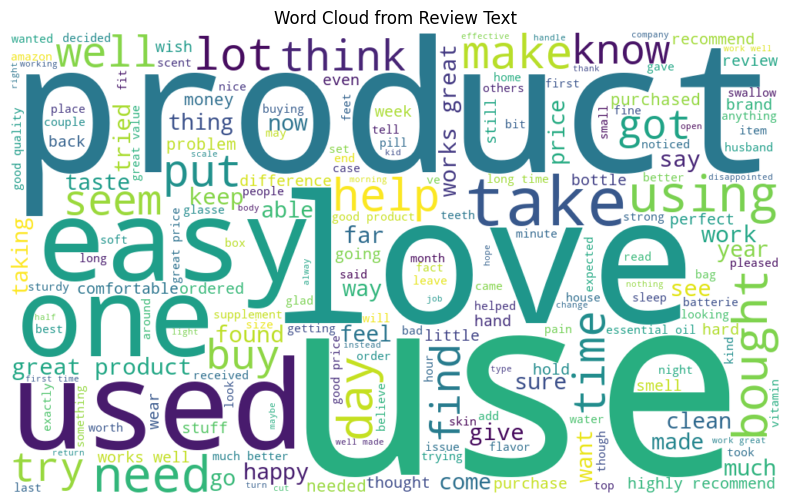

In [39]:
# Generate the word cloud
stopwords = set(STOPWORDS)

# Generate the word cloud
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    stopwords=stopwords
).generate(all_text)

# Show the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud from Review Text")
plt.show()

### RATING PIE CHART

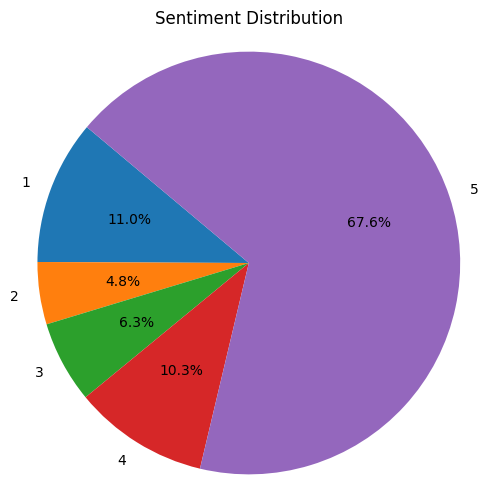

In [ ]:
# 🧼 Filter the DataFrame
filtered_df = df

# Aggregate count by sentiment
# sentiment_counts = df.groupby("sentiment")["count"].sum()
sentiment_counts = filtered_df.groupby("rating")["count"].sum()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Rating Distribution")
plt.axis("equal")
plt.show()

### SENTIMENT PIE CHART

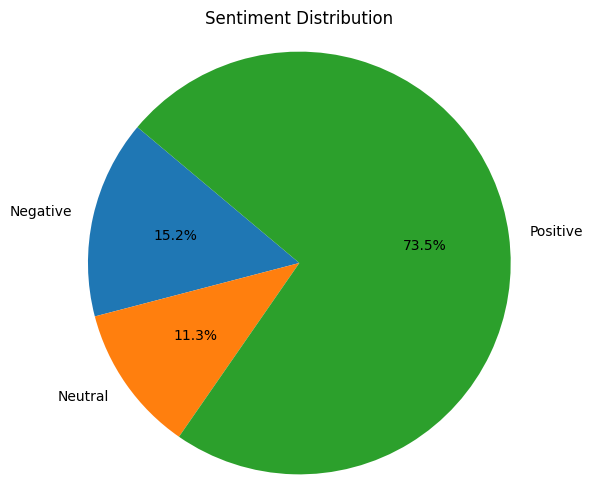

In [32]:
# 🔍 Choose the ASIN (product ID) to filter
target_asid = "B00Y2CQRZY"  # <-- change this to any ASIN you want

# 🧼 Filter the DataFrame
# filtered_df = df[df["asid"] == target_asid]

# Aggregate count by sentiment
# sentiment_counts = df.groupby("sentiment")["count"].sum()
sentiment_counts = df.groupby("sentiment")["count"].sum()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", startangle=140)
plt.title("Sentiment Distribution")
plt.axis("equal")
plt.show()

### BAR CHART

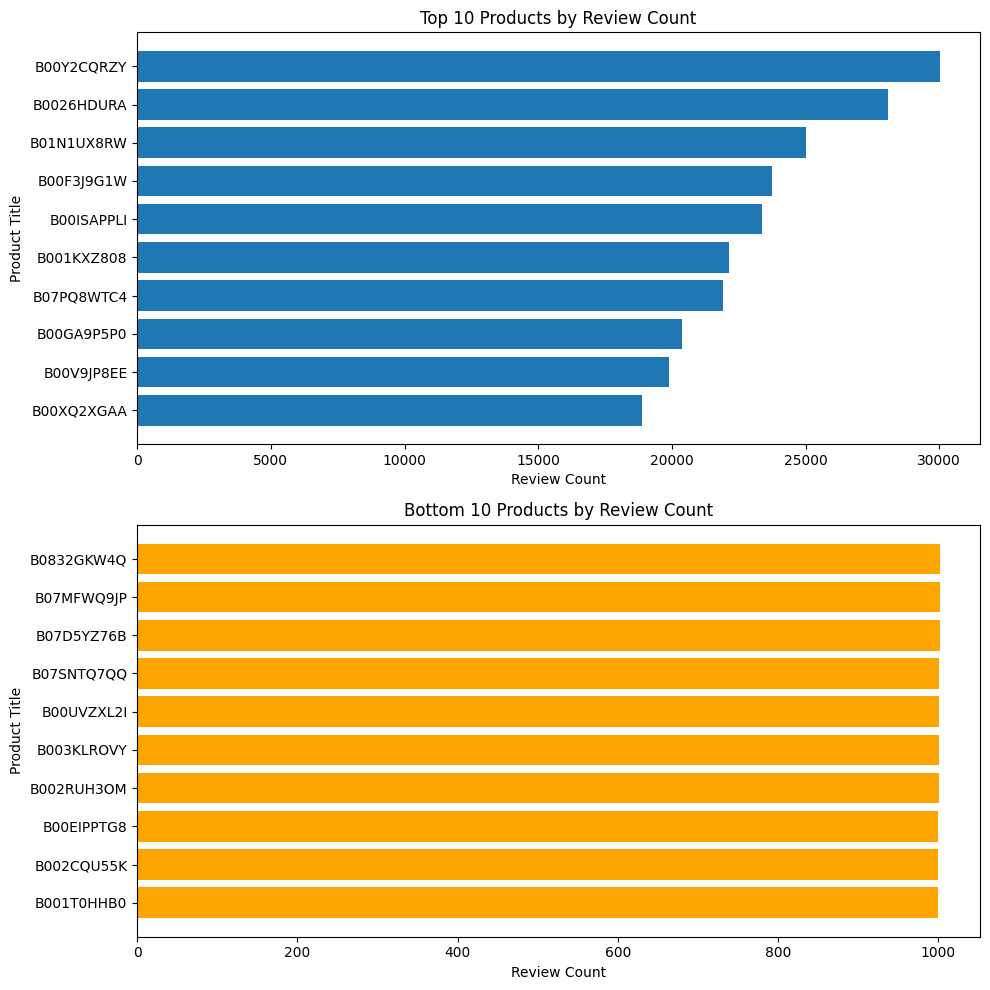

In [37]:
import matplotlib.pyplot as plt

# Group by title and sum review counts
# product_counts = df.groupby("title")["count"].sum()
product_counts = df.groupby("asid")["count"].sum()
# 🔍 Filter out products with fewer than 1000 reviews
filtered_counts = product_counts[product_counts >= 1000]

# Get Top and Bottom 10 products
top_10 = filtered_counts.nlargest(10)
bottom_10 = filtered_counts.nsmallest(10)

# print("🔝 Top 10 Products by Review Count:")
# print(top_10)
# print("\n🔻 Bottom 10 Products by Review Count:")
# print(bottom_10)

# Create subplot with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# 🔝 Top 10 - Horizontal Bar Chart
axes[0].barh(top_10.index[::-1], top_10.values[::-1])  # Reverse for highest at top
axes[0].set_title("Top 10 Products by Review Count")
axes[0].set_xlabel("Review Count")
axes[0].set_ylabel("Product Title")

# 🔻 Bottom 10 - Horizontal Bar Chart
axes[1].barh(bottom_10.index, bottom_10.values, color="orange")
axes[1].set_title("Bottom 10 Products by Review Count")
axes[1].set_xlabel("Review Count")
axes[1].set_ylabel("Product Title")

# Layout and show
plt.tight_layout()
plt.show()


### YEARLY SALES

In [24]:
df["year"].max()

np.int64(2023)

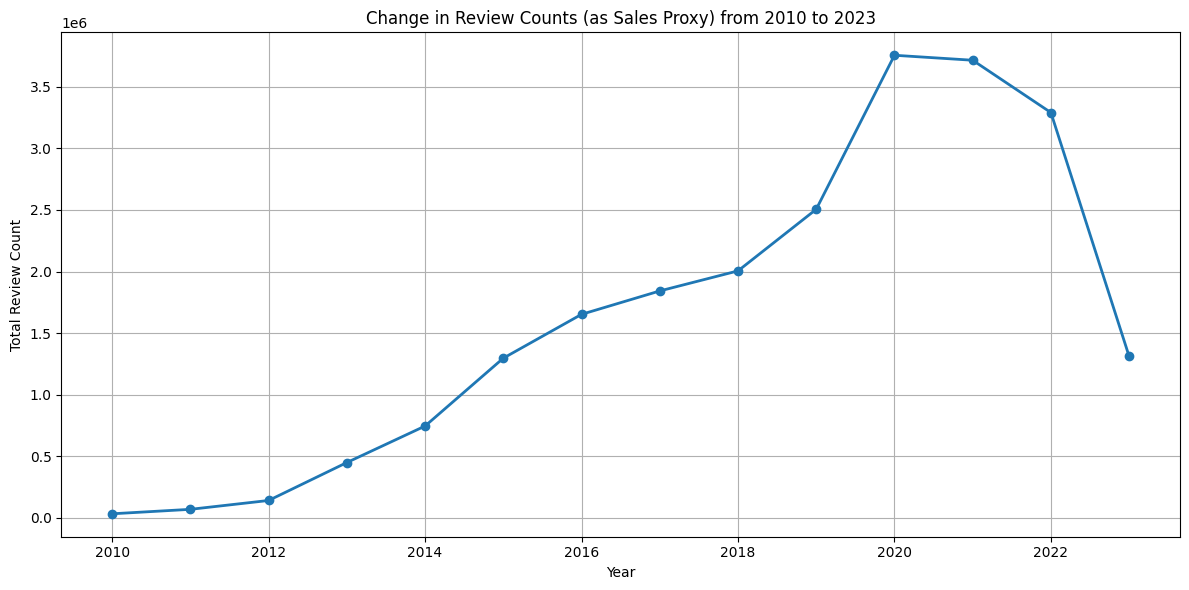

In [25]:
# Group by year and sum the review counts
yearly_sales = df.groupby("year")["count"].sum()

# Sort by year in case it's not already
yearly_sales = yearly_sales.sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(yearly_sales.index, yearly_sales.values, marker='o', linestyle='-', linewidth=2)

# Labels and Title
plt.title("Change in Review Counts (as Sales Proxy) from 2010 to 2023")
plt.xlabel("Year")
plt.ylabel("Total Review Count")
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


### RATING TRENDS

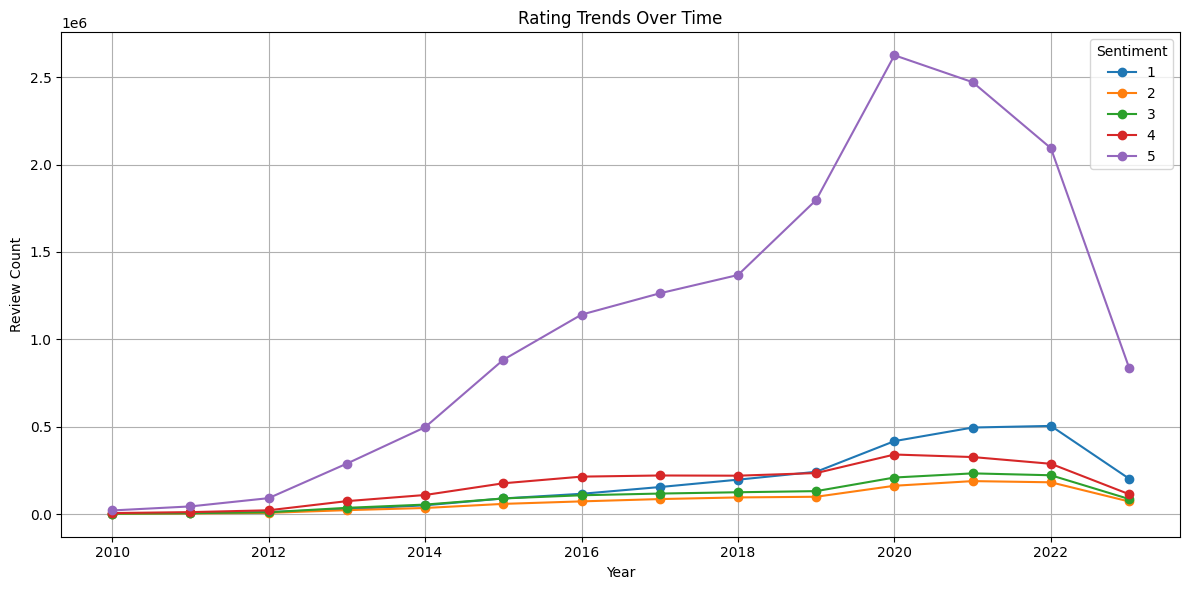

In [29]:
# Group by year and sentiment, then sum the counts
sentiment_trends = df.groupby(["year", "rating"])["count"].sum().unstack()

# Sort by year to ensure proper plotting
sentiment_trends = sentiment_trends.sort_index()

# Plotting
plt.figure(figsize=(12, 6))
for sentiment in sentiment_trends.columns:
    plt.plot(sentiment_trends.index, sentiment_trends[sentiment], marker='o', label=sentiment)

# Labels and Title
plt.title("Rating Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Review Count")
plt.legend(title="Sentiment")
plt.grid(True)
plt.tight_layout()
plt.show()